<div style="color:#3D5462;margin:0;font-size:60px;font-family:Meirio;text-align:center;display:fill;border-radius:6px;overflow:hidden;font-weight:700;"> AMP®-Parkinson's Disease Progression Prediction <br> </div>

<br>  

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>0. Table of Contents</b></div>



<div style="font-family:Meirio;background-color:whitesmoke; padding:30px; font-size:17px;color:#DB5461">
    
* [0. Table of Contents](#0)
* [1. Introduction](#1)
* [2. Imports](#2)
* [3. Library](#3)
    * [3.1 Functions](#3.1)
    * [3.2 Classes](#3.2)
* [4. Load data](#4)
* [5. Basic info](#5)
* [6. Exploratory Data Analysis](#6)
* [7. Preprocessing](#7)
* [8. Model Training](#8)
    * [Modeling](#8.2)
    * [Training](#8.3)
* [9. Explainability](#9)
    * [SHAP](#9.1)
* [10. Conclusion](#10)
* [11. Inferrence](#11)
* [12. Sources](#12)

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>1. Introduction</b></div>

## Goal of the Competition
The goal of this competition is to predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease. The Movement Disorder Society-Sponsored Revision of the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) is a comprehensive assessment of both motor and non-motor symptoms associated with Parkinson's. You will develop a model trained on data of protein and peptide levels over time in subjects with Parkinson’s disease versus normal age-matched control subjects.

Your work could help provide important breakthrough information about which molecules change as Parkinson’s disease progresses.
##  Context
Parkinson’s disease (PD) is a disabling brain disorder that affects movements, cognition, sleep, and other normal functions. Unfortunately, there is no current cure—and the disease worsens over time. It's estimated that by 2037, 1.6 million people in the U.S. will have Parkinson’s disease, at an economic cost approaching $80 billion. Research indicates that protein or peptide abnormalities play a key role in the onset and worsening of this disease. Gaining a better understanding of this—with the help of data science—could provide important clues for the development of new pharmacotherapies to slow the progression or cure Parkinson’s disease.

Current efforts have resulted in complex clinical and neurobiological data on over 10,000 subjects for broad sharing with the research community. A number of important findings have been published using this data, but clear biomarkers or cures are still lacking.

Competition host, the Accelerating Medicines Partnership® Parkinson’s Disease (AMP®PD), is a public-private partnership between government, industry, and nonprofits that is managed through the Foundation of the National Institutes of Health (FNIH). The Partnership created the AMP PD Knowledge Platform, which includes a deep molecular characterization and longitudinal clinical profiling of Parkinson’s disease patients, with the goal of identifying and validating diagnostic, prognostic, and/or disease progression biomarkers for Parkinson’s disease.

Your work could help in the search for a cure for Parkinson’s disease, which would alleviate the substantial suffering and medical care costs of patients with this disease.


## Notes and todos from the author's

- [x]  Structure the notebook 
- [x] make a local compatible version
- [x] For the current XGBoost - solution, make a dictionary with models based on the prediction-horizons. This should be done with a discussion beforehand on how to do it
- [x] Clean up the code
- [x] Add SMAPE as the metric for the model
- [x] Try a sipmler model with only visit_month=1
- [x] Do better explainability-analysis on the simple model, and make a conclusion
- [x] Try np.ceil to the predictions, seems like this is the way to go by the leaderboard
- [x] Simplyfy and modify the imputer code
- [x] Fix Imputer global vairble for online usage.
- [ ] Looks like its SMAPE+1 which is the metric, look into this 
- [ ] Try a simple ARIMA or something, since we have historical data at run-time
- [ ] Finish testing the simple Neural Network model
  - [ ] For this model fix preprocessor in IMputer class
  - [ ] Try to use shap on NN for fun. Or look into Lime for NN (?) if that exist.
- [ ] Solve bugs with NaNs in the data
  

<a id="2"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>2. Imports</b></div>

In [1]:
#!pip3 install mlflow
IS_ONLINE = False


In [46]:
import pickle
import os
import sys
import argparse
import logging
import datetime
import tqdm
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import warnings
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from pathlib import Path
from mrmr import mrmr_classif
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler


if IS_ONLINE:
    import amp_pd_peptide
else:
    import mock_api





<a id="3"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>3. Library</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

<a id="3.1"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    3.1 Functions</span>

For this competition the metric is SMAPE+1: [Discission on why here: ](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/394534)

$$ \text{SMAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|(y_i+1)| - |(\hat{y}_i+1)|}{|(y_i+1)| + |\hat{y}_i+1|} \times 200\% $$


#### Support functions


In [47]:
warnings.filterwarnings("ignore")

FLOOR = .001

In [3]:
def smape(preds, dmatrix):
    labels = dmatrix.get_label()
    diff = np.abs((labels+1) - (preds+1)) / (np.abs(labels+1) + np.abs(preds+1))
    diff = diff[~np.isnan(diff)]
    return 'SMAPE', float(np.mean(diff) * 200)

In [4]:
def smape_opt(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs((y_true+1) - (y_pred+1))
    dem = ((np.abs(y_true+1) + np.abs(y_pred+1)) / 2)
    
    pos_ind = dem != 0
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [5]:
def smape_loss(y_true, y_pred):
    """
    Function that calculates the smape loss.
    """
    return tf.reduce_mean(tf.abs((y_pred+1) - (y_true+1)) / (tf.abs(y_true+1) + tf.abs(y_pred+1)))


#### Data Pipelines and feature engineering

In [6]:
def run_test_pipeline(df_peptides,df_proteins,df_test,imputer_path):
    df_peptides = sum_peptide_abundance(df_peptides)
    df_peptides = std_peptide_abundance(df_peptides)
    df_peptides = min_peptide_abundance(df_peptides)
    df_peptides = max_peptide_abundance(df_peptides)
    df_peptides = median_peptide_abundance(df_peptides)
    df_peptides = count_peptides(df_peptides)


    # feature engineering on Protein data:
    df_proteins = sum_protein_NPX(df_proteins)
    df_proteins = std_protein_NPX(df_proteins)
    df_proteins = min_protein_NPX(df_proteins)
    df_proteins = max_protein_NPX(df_proteins)
    df_proteins = median_protein_NPX(df_proteins)
    df_proteins = count_proteins(df_proteins)

    print("Done with feature engineering...")

    # Merge dataframes:
    df_test = merge_peptides_to_clinical(df_peptides, df_test)
    df_test = merge_proteins_to_clinical(df_proteins, df_test)

   
    # load pic
    
    imp_object = pickle.load(open(imputer_path, "rb"))
    
    # all cols: 
    #unpickle imputer:
    cols = ['visit_month','PeptideAbundanceSum','PeptideAbundanceStd','PeptideAbundanceMin','PeptideAbundanceMax','PeptideAbundanceMedian','PeptideCount','NPXSum','NPXStd','NPXMin','NPXMax','NPXMedian','ProteinCount']
    X_clinilcal = df_test[cols]
    X_rest = df_test.drop(cols,axis=1)
    X_clinilcal = imp_object.transform(X_clinilcal)
    # merge X_clinical and y_clinical:

    #make X_clinical a dataframe:
    X_clinilcal = pd.DataFrame(X_clinilcal,columns=cols)

    X_all = pd.concat([X_clinilcal, X_rest], axis=1)
    
    return X_all

In [7]:
def run_train_pipeline_deep_learning(IS_ONLINE,IS_TEST,test_peptides,test_proteins,test, list_of_old_peptides,list_of_old_proteins):

    # drop upd23_clinical_state_on_medication column, because it is all NaN:
    if IS_TEST == True:
        df_peptides = test_peptides
        df_proteins = test_proteins
        df_clinical = test
    else:
        df_peptides = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
        df_proteins = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
        df_clinical = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

    if IS_TEST == True:
       
        # add a column for each peptide and protein to the clinical data, fill with NaN:
        for peptide in list_of_old_peptides:
            df_clinical[peptide] = np.nan
        for protein in list_of_old_proteins:
            df_clinical[protein] = np.nan
    else:
        # add a column for each peptide and protein to the clinical data
        list_of_peptides = df_peptides["Peptide"].unique()
        list_of_proteins = df_proteins["UniProt"].unique()
        # add a column for each peptide and protein to the clinical data, fill with NaN:
        for peptide in list_of_peptides:
            df_clinical[peptide] = np.nan
        for protein in list_of_proteins:
            df_clinical[protein] = np.nan



    #Fill the new empty columns with the values from the peptide and protein dataframes:
    for index, row in df_peptides.iterrows():
        try:
            
            df_clinical.loc[df_clinical["visit_id"] == row["visit_id"], row["Peptide"]] = row["PeptideAbundance"]
        except:
            continue
    for index, row in df_proteins.iterrows():
        try:
            df_clinical.loc[df_clinical["visit_id"] == row["visit_id"], row["UniProt"]] = row["NPX"]
        except:
            continue
    
    if IS_TEST == True:
        df_clinical = df_clinical.drop(columns=["patient_id","row_id"])

    else:
        df_clinical = df_clinical.drop(columns=["visit_id","patient_id","upd23b_clinical_state_on_medication"])
    
    df_clinical_updrs1 = df_clinical.copy()
    df_clinical_updrs2 = df_clinical.copy()
    df_clinical_updrs3 = df_clinical.copy()
    df_clinical_updrs4 = df_clinical.copy()

    #drop all other target columns from the copies:
    if IS_TEST == True:
        for i in range(3):
            list_of_output_dataframes = [df_clinical_updrs1, df_clinical_updrs2, df_clinical_updrs3, df_clinical_updrs4]
            
    else:
        df_clinical_updrs1 = df_clinical_updrs1.drop(columns=["updrs_2", "updrs_3", "updrs_4"])
        df_clinical_updrs2 = df_clinical_updrs2.drop(columns=["updrs_1", "updrs_3", "updrs_4"])
        df_clinical_updrs3 = df_clinical_updrs3.drop(columns=["updrs_1", "updrs_2", "updrs_4"])
        df_clinical_updrs4 = df_clinical_updrs4.drop(columns=["updrs_1", "updrs_2", "updrs_3"])

        # do this but now with a loop over all 4 target dataframes:
        list_of_dataframes = [df_clinical_updrs1, df_clinical_updrs2, df_clinical_updrs3, df_clinical_updrs4]
        list_of_target_columns = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

        list_of_output_dataframes = []
        for i in range(len(list_of_dataframes)):
            df = list_of_dataframes[i]
            target_column = list_of_target_columns[i]
            df = df.dropna(subset=[target_column])
            df = df.fillna(0)
            list_of_output_dataframes.append(df)
        #save the dataframes in list_of_output_dataframes to csv files:
        for i in range(len(list_of_output_dataframes)):
            df = list_of_output_dataframes[i]
            df.to_csv("df_clinical_updrs"+str(i+1)+".csv", index=False)

        

    #Ensure we have the same peptides and proteins in the test set as in the training set:
    if IS_TEST:
        list_of_old_peptides = list_of_old_peptides
        list_of_old_proteins = list_of_old_proteins
    else:
        list_of_old_peptides = list_of_peptides
        list_of_old_proteins = list_of_proteins
    
    return list_of_output_dataframes, list_of_old_peptides, list_of_old_proteins



In [8]:
def run_train_dataset_pipeline( imputer_path:str):
    """
    Description:
        Run the main processing pipeline.

    Input:
        - local_data_path: str, The path to the local data directory.

    Returns:
        - df: pd.DataFrame, A dataframe containing the output of the pipeline ready for training.
    """
    print("Starting train dataset pipeline...")

    df_peptides = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
    df_proteins = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
    df_clinical = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
    # feature engineering on Peptide data:
    df_peptides = sum_peptide_abundance(df_peptides)
    df_peptides = std_peptide_abundance(df_peptides)
    df_peptides = min_peptide_abundance(df_peptides)
    df_peptides = max_peptide_abundance(df_peptides)
    df_peptides = median_peptide_abundance(df_peptides)
    df_peptides = count_peptides(df_peptides)

    # feature engineering on Protein data:
    df_proteins = sum_protein_NPX(df_proteins)
    df_proteins = std_protein_NPX(df_proteins)
    df_proteins = min_protein_NPX(df_proteins)
    df_proteins = max_protein_NPX(df_proteins)
    df_proteins = median_protein_NPX(df_proteins)
    df_proteins = count_proteins(df_proteins)

    print("Done with feature engineering...")

    # Merge dataframes:
    df_clinical = merge_peptides_to_clinical(df_peptides, df_clinical)
    df_clinical = merge_proteins_to_clinical(df_proteins, df_clinical)

    

    # Encode and Impute missing values:

    # remove ID columns:
    df_clinical = df_clinical.drop(columns=['visit_id', 'patient_id','upd23b_clinical_state_on_medication'])

 
    # initialize imputer object:
    imp_object = ImputeEncode(df_clinical, imputer_path)
    
    # fit transform imputer object:
    X_clinical,y_clinical = imp_object.fit_transform()   #  <-- returns X,y pd.DataFrames

    
    # merge X_clinical and y_clinical:
    df_clinical = pd.concat([X_clinical, y_clinical], axis=1)

    

    return df_clinical

In [9]:
def feature_selection(list_of_dataframes):
    """
    Function that takes in the list of dataframes, and does feature selection on them.
    EACH model has its own feature selection, so we need to do this for each model.
    we should also return the corresponding list of columns that were selected for each model.
    """

    new_list_of_dataframes = []
    list_of_list_of_features = []
    COUNTER = 0
    for df in list_of_dataframes:
        # which loop number in the for loop is this? save to a variable:
        string_updrs = str(COUNTER+1)
        string_updrs = "updrs"+"_"+string_updrs
        
        y = df[string_updrs]
        X = df.drop(columns=[string_updrs])

        COUNTER+=1

        # try feature selection with mrmr instead of SelectKBest:
        # get the top 50 features:
        selected_features, relevance, _ = mrmr_classif(X, y, 50,return_scores=True)

        # make relevance into a dataframe from a Series:
        df_relevance = pd.DataFrame(relevance)
        # Make the index into a column, and make the index start from 0 for df_relevance:

        df_relevance = df_relevance.rename(columns={"index":"selected_features"})
        df_relevance = df_relevance.reset_index()

        # rename the column "0" to "relevance":
        df_relevance = df_relevance.rename(columns={0:"relevance"})

        # rename the column "index" to "redundancy":
        df_relevance = df_relevance.rename(columns={"index":"feature"})

        # sort the dataframe by the scores:
        df_relevance = df_relevance.sort_values(by="relevance", ascending=False)

        df_top_50 = df_relevance.head(50)
        # plot the top 50 scores-features:
        plt.figure(figsize=(20,10))
        plt.bar(range(len(df_top_50["feature"])), df_top_50["relevance"])
        plt.xticks(range(len(df_top_50["feature"])), df_top_50["feature"], rotation=90)
        plt.title("Top 50 features for UPDRS"+string_updrs[-1] + "using mrmr")
        plt.show()

        #check if visit_month is in the selected features if not add it:
        if "visit_month" not in selected_features:
            selected_features.append("visit_month")
        
        df = X[selected_features]
        df[string_updrs] = y
        list_of_list_of_features.append(selected_features)
        new_list_of_dataframes.append(df)
    return new_list_of_dataframes, list_of_list_of_features


    


In [10]:
def sum_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'sum'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceSum'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def std_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'std'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceStd'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def min_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'min'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceMin'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def max_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'max'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceMax'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def median_peptide_abundance(df_peptides):
    df_peptides_abundance = df_peptides.groupby(['visit_id']).agg({'PeptideAbundance': 'median'}).reset_index()
    df_peptides_abundance.rename(columns={'PeptideAbundance': 'PeptideAbundanceMedian'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_abundance, on='visit_id', how='left')
    return df_peptides

def count_peptides(df_peptides):
    df_peptides_count = df_peptides.groupby(['visit_id']).agg({'Peptide': 'count'}).reset_index()
    df_peptides_count.rename(columns={'Peptide': 'PeptideCount'}, inplace=True)
    df_peptides = df_peptides.merge(df_peptides_count, on='visit_id', how='left')
    return df_peptides

# proteins feauture-engineering:
# dulicate the peptides feature-engineering functions for proteins, change PeptideAbundance to NPX:
def sum_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'sum'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXSum'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def std_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'std'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXStd'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def min_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'min'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXMin'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def max_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'max'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXMax'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def median_protein_NPX(df_proteins):
    df_proteins_NPX = df_proteins.groupby(['visit_id']).agg({'NPX': 'median'}).reset_index()
    df_proteins_NPX.rename(columns={'NPX': 'NPXMedian'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_NPX, on='visit_id', how='left')
    return df_proteins

def count_proteins(df_proteins):
    df_proteins_count = df_proteins.groupby(['visit_id']).agg({'UniProt': 'count'}).reset_index()
    df_proteins_count.rename(columns={'UniProt': 'ProteinCount'}, inplace=True)
    df_proteins = df_proteins.merge(df_proteins_count, on='visit_id', how='left')
    return df_proteins



def merge_peptides_to_clinical(df_peptides, df_clinical):
    """
    Merge the new features to the clinical dataframe.
    """
    
    # make a new dataframe with only visit_id and the new features:
    df_new = df_peptides[['visit_id', 'PeptideAbundanceSum', 'PeptideAbundanceStd', 'PeptideAbundanceMin', 'PeptideAbundanceMax', 'PeptideAbundanceMedian', 'PeptideCount']]
    # make df_peptides_new unique on visit_id:
    df_new = df_new.drop_duplicates(subset=['visit_id'])
    # merge the new features to the clinical dataframe:
    df_clinical = df_clinical.merge(df_new, on='visit_id', how='left')

    return df_clinical

def merge_proteins_to_clinical(df_proteins, df_clinical):
    """
    Merge the new features to the clinical dataframe.
    """
    # make a new dataframe with only visit_id and the new features:
    df_new = df_proteins[['visit_id', 'NPXSum', 'NPXStd', 'NPXMin', 'NPXMax', 'NPXMedian', 'ProteinCount']]
    # make df_peptides_new unique on visit_id:
    df_new = df_new.drop_duplicates(subset=['visit_id'])
    # merge the new features to the clinical dataframe:
    df_clinical = df_clinical.merge(df_new, on='visit_id', how='left')

    return df_clinical

        
    
        

#### Train Functions

In [11]:
def optimize(train):
    estimates = {}
    months = train.visit_month.unique()
    targets = [ 'updrs_1','updrs_2', 'updrs_3']
    for m in months:
        for target in targets:
            t = train[train.visit_month==m][f'{target}'].dropna().values
            if len(t) >= 200:
                s = []
                best_threshold = 0
                best_smape = 200
                for i in np.arange(0, 30, 0.1):
                    score = smape_opt(t, np.array([i for _ in range(len(t))]))
                    s.append(score)
                    if score < best_smape:
                        best_smape = score
                        best_threshold = i
            else:
                best_threshold = np.median(t)
            estimates[(m, target)] = best_threshold

    for i in range(sorted(months)[-1]+1):
        for target in targets:
            if (i, target) not in estimates:
                estimates[(i, target)] = estimates[(i-1, target)]
    return estimates

In [12]:
def train_neural_networks(dfs_cleaned):
    """
    Input: list of dataframes
    Ouput: Struct with the models
    """
    models = {}

    # do a loop over all 4 dataframes:
    for i in range(len(dfs_cleaned)):
        df = dfs_cleaned[i]
        y = df["updrs_"+str(i+1)]
        X = df.drop(columns=["updrs_"+str(i+1)])

        # do train test split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # define the model:
        model = Sequential()
        model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation='linear'))

        #use smape as loss function:
        model.compile(loss=smape_loss, optimizer='adam', metrics=[smape_loss])
        history = model.fit(X_train, y_train, epochs=300, verbose=0)
        y_pred = model.predict(X_test)

        #make a plot of the loss function:
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        models["updrs_"+str(i+1)] = model


    return models

In [13]:
def train_LinReg(dfs_cleaned):
    """
    Input: list of dataframes
    Ouput: Struct with the models
    """
    models = {}

    # do a loop over all 4 dataframes:
    for i in range(len(dfs_cleaned)):
        df = dfs_cleaned[i]
        y = df["updrs_"+str(i+1)]
        X = df.drop(columns=["updrs_"+str(i+1)])

        # do train test split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
        print("SMAPE: ", smape(y_test, y_pred))

        models["model_"+str(i+1)] = model
    return models

In [14]:
def train_xgboost(search_space, name, df_copy):
    """
    Train script with hyperparameters
    """

    def objective(search_space):
        """
        Encapsulated objective-function such that hyperopt function can reach input-data in objective function
        """
        global BEST_SMAPE
        global current_best_model
        dtrain = xgb.DMatrix(X_train.copy(), label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test.copy(), label=y_test, enable_categorical=True)
        evallist = [(dtest, "eval"), (dtrain, "train")]


        verbose_eval = 1000

        with mlflow.start_run(nested=True):
            num_round = 1000
            evals_result = {}
            num_features = 80
            bst = xgb.train(
                search_space,
                dtrain,
                num_round,
                evals=evallist,
                evals_result=evals_result,
                early_stopping_rounds=50,
                verbose_eval=verbose_eval,
                feval=smape,
            )
            print(f"Stopping after {len(evals_result['train']['SMAPE'])} rounds")

            min_eval_error = np.min(evals_result["eval"]["SMAPE"])
            mlflow.xgboost.log_model(bst, artifact_path="model")

            #Make the current_best_model global:
            print(min_eval_error,"min_eval_error")
            print(BEST_SMAPE)
            
            if min_eval_error < BEST_SMAPE:
                BEST_SMAPE = min_eval_error
                current_best_model = bst
            
        #return the best model together with status ok, attributes and the best model:
        return {'loss': min_eval_error, 'status': STATUS_OK, 'model': current_best_model, 'booster': bst.attributes()}
        

       


    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment(name)

    mlflow.xgboost.autolog(
        log_input_examples=False, log_model_signatures=True, log_models=True
    )

    df_copy = df_copy.copy()
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    X_cols = [col for col in df_copy.columns if col not in y_cols]
    # Define X and y:
    X = df_copy[X_cols]
    y = df_copy[y_cols]
        # train only on the data where visit_month = months:
    X = X[X['visit_month'] == 0]
    #y indexes from X:
    y = y.loc[X.index]
    models_dict={}
    for i in y_cols:
        global BEST_SMAPE
        global current_best_model
        BEST_SMAPE = 100000
        current_best_model = None
        y_new = y[i]
        #Fill nan with mean:
        y_new = y_new.fillna(y_new.mean())

        # dividing X, y into train and test data. Random seed is specified in params dict form jsonfile
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_new, test_size=0.20, random_state=search_space["seed"]
        )

        # Use dataset shortname in run name along with model type. Better ideas?
        # import pathlib


        # -------INIT DONE----
        print("Dataset loaded, split into train test... ready to run hyperoptimalization!")

        with mlflow.start_run(run_name=f"xgb_{i}"):
            best_params = fmin(
                fn=objective,
                space=search_space,
                algo=tpe.suggest,
                max_evals=10,
            )
        print(best_params)
        # get the best model from the best params:
        best_model = current_best_model
            # save the best model to models_dict:
        models_dict[i] = best_model  
   
   
    return models_dict

In [15]:
def train_no_mlflow(search_space, name, df_copy):

    def objective(search_space):
        """
        Encapsulated objective-function such that hyperopt function can reach input-data in objective function
        """
        global BEST_SMAPE
        global current_best_model
        dtrain = xgb.DMatrix(X_train.copy(), label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test.copy(), label=y_test, enable_categorical=True)
        evallist = [(dtest, "eval"), (dtrain, "train")]


        verbose_eval = 1000

    
        num_round = 1000
        evals_result = {}
        num_features = 80
        bst = xgb.train(
            search_space,
            dtrain,
            num_round,
            evals=evallist,
            evals_result=evals_result,
            early_stopping_rounds=50,
            verbose_eval=verbose_eval,
            feval=smape,
        )
        print(f"Stopping after {len(evals_result['train']['SMAPE'])} rounds")
        min_eval_error = np.min(evals_result["eval"]["SMAPE"])

        #Make the current_best_model global:
        print(min_eval_error,"min_eval_error")
        print(BEST_SMAPE)
        
        if min_eval_error < BEST_SMAPE:
            BEST_SMAPE = min_eval_error
            current_best_model = bst
        
        #return the best model together with status ok, attributes and the best model:
        return {'loss': min_eval_error, 'status': STATUS_OK, 'model': current_best_model, 'booster': bst.attributes()}
        
    df_copy = df_copy.copy()
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    X_cols = [col for col in df_copy.columns if col not in y_cols]
    # Define X and y:
    X = df_copy[X_cols]
    y = df_copy[y_cols]
    
    #y indexes from X:
    y = y.loc[X.index]  
    models_dict={}
    for i in y_cols:
        global BEST_SMAPE
        global current_best_model
        BEST_SMAPE = 100000
        current_best_model = None
        y_new = y[i]
        #Fill nan with mean:
        y_new = y_new.fillna(y_new.mean())

        # dividing X, y into train and test data. Random seed is specified in params dict form jsonfile
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_new, test_size=0.20, random_state=search_space["seed"]
        )

        # Use dataset shortname in run name along with model type. Better ideas?
        # import pathlib


        # -------INIT DONE----
        print("Dataset loaded, split into train test... ready to run hyperoptimalization!")

    
        best_params = fmin(
            fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=10,
        )
        print(best_params)
        # get the best model from the best params:
        best_model = current_best_model
            # save the best model to models_dict:
        models_dict[i] = best_model
    return models_dict

#### Inference and predictions

In [16]:
def get_predictions_single_month_simple_imputer(models, peptides,proteins,test):
    """
    Function to get predictions from a list of models and a test set
    """
    
    # run test pipeline: 
    imputer_path = "../input/imputer/imputer.pkl"
    df_test = run_test_pipeline(peptides,proteins,test,imputer_path)

   
    result = pd.DataFrame()
    plus_months = [0,6,12,24]
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]

    #for unique patient_id:
    for visit_id in df_test["visit_id"].unique():
        for plus_month in plus_months:
            for udprs in y_cols:
                model = models[udprs] 
                #get the y_col:
                y_col = udprs
                #PREDICTION_ID: 3342_0_updrs_1_plus_0_months = "patient_id" + "_" + "visit_month" + "_" + updrs_test + "_" +  "plus_" + "prediction_month" +  "months
                prediction_id = str(visit_id) + "_" + y_col + "_" + "plus_" + str(plus_month) + "_months"
                
                #get the rating:
                #get the row from the df_test:
                df_test_row = df_test[df_test["visit_id"] == visit_id]
                #get the X_test:
                X_test = df_test_row[[  'visit_month',
                                        'PeptideAbundanceSum',
                                        'PeptideAbundanceStd',
                                        'PeptideAbundanceMin',
                                        'PeptideAbundanceMax',
                                        'PeptideAbundanceMedian',
                                        'PeptideCount',
                                        'NPXSum',
                                        'NPXStd',
                                        'NPXMin',
                                        'NPXMax',
                                        'NPXMedian',
                                        'ProteinCount']]
                #fill missing values with 0:
                X_test = X_test.fillna(0)
                X_test['visit_month'] = X_test['visit_month'] + plus_month
                
                #use concat instead of append, and dont pass group_key:

                result = pd.concat([result,pd.DataFrame({"prediction_id":prediction_id,"rating":model.predict(xgb.DMatrix(X_test))[0]},index=[0])],ignore_index=True)
    
    #if any of the predictions are negative, set them to 0:
    result.loc[result["rating"] < 0, "rating"] = 0

    #round the rating to nearest interger:
    # print results before rounding:
    result["rating"] = result["rating"].round(0)

    
    return result

In [17]:
def get_predictions_xgboost(models, peptides,proteins,test):
    """
    Function to get predictions from a list of models and a test set
    """
    # prediction_id = 3342_0_updrs_1_plus_0_months = "patient_id" + "_" + "visit_month" + "_" + updrs_test + "_" +  "plus_" + "prediction_month" +  "months"
    # define the smaple submission: 
    
    # run test pipeline: 
    imputer_path = "../input/imputer/imputer.pkl"
    #imputer_path = "../../config/imputer/preprocessor.pkl2023-03-14 12:43:15.199921preprocessor.pkl2023-03-15 12:58:42.803874"
    df_test = run_test_pipeline(peptides,proteins,test,imputer_path)

    # get predictions for each model:
    #if updrs_test = updrs_1, updrs_2, updrs_3, updrs_4: run the corresponding model: models[0], models[1], models[2], models[3]:
    # run each for the month 0, 6, 12, 24: where visit_month gets replaced = 0, 6, 12, 24
    # 
    result = pd.DataFrame()
    plus_months = [0,6,12,24]
    y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    LIST_OF_MODELMONTHS = [0,6,12,18,24,30,36,42,48,54,60,72,84,96]
    #for unique patient_id:
    print(df_test["visit_id"].unique())
    print(df_test["visit_month"].unique())
    for visit_id in df_test["visit_id"].unique():
        for visit_month in df_test["visit_month"].unique():
            for udprs in y_cols:
                for plus_month in plus_months:
                    
                    #get the model:
                    if plus_month+visit_month > 96:
                        model = models[udprs+"_"+str(96)]
                    
                    #if model is not in the list of models:
                    elif udprs+"_"+str(int(plus_month)+int(visit_month)) not in models:

                        model_nr = plus_month+visit_month
                        
                        for i in range(len(LIST_OF_MODELMONTHS)):
                            if LIST_OF_MODELMONTHS[i] > model_nr:
                                model = models[udprs+"_"+str(LIST_OF_MODELMONTHS[i-1])]


                    else:
                        model = models[udprs+"_"+str(int(plus_month)+int(visit_month))] # TODO change this line:
                    #get the y_col:
                    y_col = udprs
                    #PREDICTION_ID: 3342_0_updrs_1_plus_0_months = "patient_id" + "_" + "visit_month" + "_" + updrs_test + "_" +  "plus_" + "prediction_month" +  "months
                    prediction_id = str(visit_id) + "_" + y_col + "_" + "plus_" + str(plus_month) + "_months"
                    #get the group_key:
                    #get the rating:
                    #get the row from the df_test:
                    df_test_row = df_test[df_test["visit_id"] == visit_id]
                    #get the X_test:
                    X_test = df_test_row[['visit_month',
                                            'PeptideAbundanceSum',
                                            'PeptideAbundanceStd',
                                            'PeptideAbundanceMin',
                                            'PeptideAbundanceMax',
                                            'PeptideAbundanceMedian',
                                            'PeptideCount',
                                            'NPXSum',
                                            'NPXStd',
                                            'NPXMin',
                                            'NPXMax',
                                            'NPXMedian',
                                            'ProteinCount']]
                    #fill missing values with 0:
                    X_test = X_test.fillna(0)
                    X_test['visit_month'] = X_test['visit_month'] + plus_month
                    
                    # use the correct model to predict:
                    #
                    #result = result.append({"prediction_id":prediction_id,"rating":model.predict(xgb.DMatrix(X_test))[0]},ignore_index=True)#,"group_key":group_key},ignore_index=True)

                    #use concat instead of append, and dont pass group_key:
                    result = pd.concat([result,pd.DataFrame({"prediction_id":prediction_id,"rating":model.predict(xgb.DMatrix(X_test))[0]},index=[0])],ignore_index=True)
    
            
            
        


    
        
        
    

    return result #pd.DataFrame: | prediction_id | rating | group_key |

<a id="3.2"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    3.2 Classes</span>
    
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

In [18]:
class ImputeEncode():
    """
    Impute missing values, and encode variables.
    Columns of dtype object are imputed with the most frequent value
    in column.
    Columns of other types are imputed with median of column.
    """
    def __init__(self,df, imputer_path, **kwargs):
        self.ISKAGGLE=True
        self.X_cols = [col for col in df.columns if col not in ['updrs_1','updrs_2','updrs_3','updrs_4']]
        self.y_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']
        self.X = df[self.X_cols]
        self.y = df[self.y_cols]
        self.categorical_pipeline = None
        self.numerical_pipeline = None
        self.preprocessor = None
        self.imputer_path = imputer_path
        self.categorical_columns = [col for col in self.X.columns if self.X[col].dtype == 'object']
        self.numerical_columns = [col for col in self.X.columns if self.X[col].dtype != 'object']
        self.preprocessor_y = None
        # if kwargs containes a string to a imputer file load it with pickle and assign it to self.preprocessor
        if 'imputer_path_file' in kwargs:
            self.preprocessor = pickle.load(open(kwargs['imputer_path_file'], 'rb'))


    def fit(self):
        """
        Take in a X: pandas dataframe, and return self.

        Parameters:
        X (pandas dataframe): The dataframe to fit the imputer on.
        y (pandas series): The target variable.

        Returns:
        X (pandas dataframe): The dataframe with imputed values.
        y (pandas series): The target variable with imputed values.
        """
        # run a impute and encode pipeline on the categorical columns:
        self.categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])
        # run a impute and encode pipeline on the numerical columns:
        self.numerical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        # combine the categorical and numerical pipelines:
        self.preprocessor = ColumnTransformer([
            ('categorical', self.categorical_pipeline, self.categorical_columns),
            ('numerical', self.numerical_pipeline, self.numerical_columns)
        ])
        # fit the preprocessor:
        self.preprocessor.fit(self.X, self.y)
        
        # save the preprocessor to pickle:
        # path to save it to: config/pickles/preprocessor.pkl
        # check if the directory exists, if not, create it:
        if self.ISKAGGLEis ==True:
            print("skipping model save")
        else:
            
            if not os.path.exists(self.imputer_path):
                os.makedirs(self.imputer_path)
            # save the preprocessor to pickle:
            FILENAME = 'preprocessor.pkl' + str(datetime.datetime.now())
            with open(self.imputer_path + FILENAME, 'wb') as f:
                pickle.dump(self.preprocessor, f)

        
        # return the imputed and encoded X and y as dataframes:

        return self.preprocessor
    

    def fit_transform(self):
        """
        Take in a X: pandas dataframe, and return self.
        """
        #encode:
        X = self.X
        y = self.y
        #fit:
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.preprocessor = imp.fit(X)
        X = imp.transform(X)
        if self.ISKAGGLE ==True:
            print("skippping")
        else:
            # save the preprocessor to pickle:
            if not os.path.exists(self.imputer_path):
                os.makedirs(self.imputer_path)

            FILENAME = str(datetime.datetime.now()) + 'preprocessor.pkl'
            with open(self.imputer_path + FILENAME, 'wb') as f:
                pickle.dump(self.preprocessor, f)

        self.preprocessor_y = imp.fit(y)
        
        #transform and return:
        X = pd.DataFrame(X, columns=self.X_cols)
        y = pd.DataFrame(y, columns=self.y_cols)

        return X,y
    
    def fit_transform_simple(self):
        """
        Take in a X: pandas dataframe, and return self. No functional difference from fit_transform, but functionality will be added later.
        """

        #encode:
        X = self.X
        y = self.y

        #fit:
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.preprocessor = imp.fit(X)
        X = imp.transform(X)

        # save the preprocessor to pickle:
        if not os.path.exists(self.imputer_path):
            os.makedirs(self.imputer_path)
            
        FILENAME = str(datetime.datetime.now()) + 'preprocessor.pkl'
        with open(self.imputer_path + FILENAME, 'wb') as f:
            pickle.dump(self.preprocessor, f)

        self.preprocessor_y = imp.fit(y)
        
        #transform and return:
        X = pd.DataFrame(X, columns=self.X_cols)
        y = pd.DataFrame(y, columns=self.y_cols)

        return X,y
        


In [19]:
def scale_fit_transform_NeuralNetwork(models_nn, IS_FIT,scalers,list_of_list_of_features):
    """
    Take in a list of neural network models, and return a list of scaled, fitted and transformed neural network models.

    Parameters:
    models_nn (list): A list of neural network models. and a scaler list

    Returns:
    models_nn (list): A list of neural network models. and a scaler list
    """
    updrs_map = {0: 'updrs_1', 1: 'updrs_2', 2: 'updrs_3', 3: 'updrs_4'}
    temp_models = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
    if IS_FIT:
        
        scalers = [MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()]
        for i in range(len(scalers)):
            # fit the data to the scaler:
            print(i)
            #drop columns that are not needed for the scaler:
            temp_models[i] = models_nn[i].drop(columns=updrs_map[i])
            #scaler fit:
            scalers[i].fit(temp_models[i])
            # transform the data:
            
            
    else: 
        #drop the columns that are not needed for the scaler:
        
        #ensure that the right columns are passed: 
        for i in range(len(models_nn)):
            models_nn[i] = models_nn[i][list_of_list_of_features[i]]

        for i in range(len(models_nn)):
            models_nn[i]= scalers[i].transform(models_nn[i])
        #return the models as dataframes:
        for i in range(len(models_nn)):
            models_nn[i] = pd.DataFrame(models_nn[i], columns=list_of_list_of_features[i])
        
        
    return models_nn, scalers

<a id="4"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>4. Load Data</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>


<a id="5"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>5. Basic dataset infofmation</b></div>

<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

    

Cerebrospinal fluid (CSF, shown in blue) is made by tissue that lines the ventricles (hollow spaces) in the brain. It flows in and around the brain and spinal cord to help cushion them from injury and provide nutrients.

<a id="6"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>6. Exploratory Data Analysis</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>



 **Data description df_peptides**

**Description:**
df_peptides.csv Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

From: 
df_peptides.csv
1. **visit_id** - ID code for the visit.
2. **visit_month** - The month of the visit, relative to the first visit by the patient.
3. **patient_id** - An ID code for the patient.
4. **UniProt** - The UniProt ID code for the associated protein. There are often several peptides per protein.
5. **Peptide** - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table.
6. **PeptideAbundance** - The frequency of the amino acid in the sample.



**Data description df_proteins**
**Description:**
Protein expression frequencies aggregated from the peptide level data.
From:
train_proteins.csv 

1. **visit_id** - ID code for the visit.
2. **visit_month** - The month of the visit, relative to the first visit by the patient.
3. **patient_id** - An ID code for the patient.
4. **UniProt** - The UniProt ID code for the associated protein. There are often several peptides per protein.
5. **NPX** - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.
 

**Data description df_clinical_data**
**Description:**
Clinical data for each patient. This data is collected at the time of the visit.
From:
train_clinical_data.csv

1. **visit_id** - ID code for the visit.
2. **visit_month** - The month of the visit, relative to the first visit by the patient.
3. **patient_id** - An ID code for the patient.
4. **updrs_[1-4]** - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
5. upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.




In [20]:
# load the 3 datasets:
df_peptides_EDA = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
df_proteins_EDA = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
df_clinical_EDA = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")




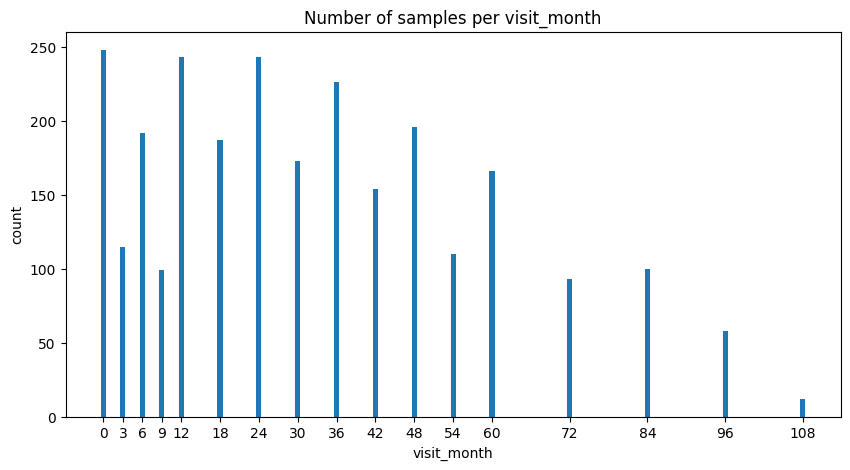

In [21]:
# count number of samples where visit_month = [0,6,12,18,24,30] respectively:
a = df_clinical_EDA['visit_month'].value_counts()

# plot it and make the months cronological on the x-axis:
plt.figure(figsize=(10,5))
plt.bar(a.index,a.values)
plt.xticks(a.index)
plt.xlabel('visit_month')
plt.ylabel('count')
plt.title('Number of samples per visit_month')
plt.show()



Number of samples per month decreases significantly, thus we have to be smart about choosing a time-series predictor model

In [22]:
# Define args to pipeline:
imputer_path = "../input/imputer/"
df_EDA = run_train_dataset_pipeline(imputer_path)



Starting train dataset pipeline...
Done with feature engineering...
skippping


In [23]:
#show more columns and rows:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df_EDA

,visit_month,PeptideAbundanceSum,PeptideAbundanceStd,PeptideAbundanceMin,PeptideAbundanceMax,PeptideAbundanceMedian,PeptideCount,NPXSum,NPXStd,NPXMin,NPXMax,NPXMedian,ProteinCount,updrs_1,updrs_2,updrs_3,updrs_4
0,0.0,6.965313e+08,4.231806e+06,2148.350000,9.970120e+07,93134.800000,931.000000,6.965313e+08,2.672700e+07,3417.710000,3.902390e+08,123757.000000,219.000000,10.0,6.0,15.0,NaN
1,3.0,5.672345e+08,3.321411e+06,202.807182,7.132767e+07,75233.648923,881.782772,5.672345e+08,2.187820e+07,1919.833074,3.105057e+08,115353.151592,209.052434,10.0,7.0,25.0,NaN
2,6.0,6.413646e+08,3.491859e+06,1444.290000,7.759770e+07,84814.900000,936.000000,6.413644e+08,2.391469e+07,2505.100000,3.475720e+08,129048.000000,218.000000,8.0,10.0,34.0,NaN
3,9.0,5.672345e+08,3.321411e+06,202.807182,7.132767e+07,75233.648923,881.782772,5.672345e+08,2.187820e+07,1919.833074,3.105057e+08,115353.151592,209.052434,8.0,9.0,30.0,0.0
4,12.0,6.983249e+08,3.882536e+06,2814.330000,8.651350e+07,91575.200000,943.000000,6.983249e+08,2.612674e+07,3592.520000,3.835070e+08,124498.000000,222.000000,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,48.0,6.272385e+08,3.243698e+06,117.149000,6.498220e+07,87860.400000,937.000000,6.272391e+08,2.171818e+07,3137.070000,3.066470e+08,122495.000000,215.000000,7.0,6.0,13.0,0.0
2611,54.0,5.672345e+08,3.321411e+06,202.807182,7.132767e+07,75233.648923,881.782772,5.672345e+08,2.187820e+07,1919.833074,3.105057e+08,115353.151592,209.052434,4.0,8.0,11.0,1.0
2612,60.0,5.672345e+08,3.321411e+06,202.807182,7.132767e+07,75233.648923,881.782772,5.672345e+08,2.187820e+07,1919.833074,3.105057e+08,115353.151592,209.052434,6.0,6.0,16.0,1.0
2613,72.0,5.672345e+08,3.321411e+06,202.807182,7.132767e+07,75233.648923,881.782772,5.672345e+08,2.187820e+07,1919.833074,3.105057e+08,115353.151592,209.052434,3.0,9.0,14.0,1.0


<a id="7"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>7. Data Preprocessing</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    
    
    All the data preprocessing are defined in functions and is called from the run_pipeline function

In [24]:
test_peptides = pd.DataFrame()
test_proteins = pd.DataFrame()
test = pd.DataFrame()
list_of_old_peptides = []
list_of_old_proteins = []
IS_TEST = False
list_of_dataframes, list_of_old_peptides,list_of_old_proteins = run_train_pipeline_deep_learning(IS_ONLINE,IS_TEST,test_peptides,test_proteins,test, list_of_old_peptides,list_of_old_proteins)

In [25]:
print(list_of_old_peptides)
print(list_of_old_proteins)

['NEQEQPLGQWHLS' 'GNPEPTFSWTK' 'IEIPSSVQQVPTIIK'
 'KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK' 'SMEQNGPGLEYR'
 'TLKIENVSYQDKGNYR' 'VIAVNEVGR' 'VMTPAVYAPYDVK' 'VNGSPVDNHPFAGDVVFPR'
 'ELDLNSVLLK' 'HGTC(UniMod_4)AAQVDALNSQKK' 'ALPGTPVASSQPR'
 'LFGGNFAHQASVAR' 'LYQQHGAGLFDVTR' 'VTEPISAESGEQVER' 'AYQGVAAPFPK'
 'QQETAAAETETR' 'THLGEALAPLSK' 'ASGSPEPAISWFR' 'NIINSDGGPYVC(UniMod_4)R'
 'TALASGGVLDASGDYR' 'TQSSLVPALTDFVR' 'ALMSPAGMLR' 'GLYDVVSVLR'
 'SEGLLAC(UniMod_4)GTNAR' 'ILEVVNQIQDEER' 'QALNTDYLDSDYQR'
 'ADDLGKGGNEESTKTGNAGSR' 'TLVVHEKADDLGKGGNEESTK' 'ALYLQYTDETFR'
 'EVGPTNADPVC(UniMod_4)LAK' 'FNKNNEGTYYSPNYNPQSR' 'GAYPLSIEPIGVR'
 'KAEEEHLGILGPQLHADVGDKVK' 'MFTTAPDQVDKEDEDFQESNK'
 'MYYSAVDPTKDIFTGLIGPM(UniMod_35)K' 'NNEGTYYSPNYNPQSR' 'QYTDSTFRVPVER'
 'SVPPSASHVAPTETFTYEWTVPK' 'DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR'
 'ELLESYIDGR' 'LAVTTHGLPC(UniMod_4)LAWASAQAK'
 'RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR'
 'SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR' 'SGIEC(UniMod_4)QLWR'
 'TATSEYQTFFNPR' 'MGNFPWQVFT

In [26]:
df = run_train_dataset_pipeline( imputer_path)

Starting train dataset pipeline...
Done with feature engineering...
skippping


<a id="8"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>8. Model Training</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

<a id="8.1"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    8.1 Modeling </span>

#### For Deep Learning feature engineering per model:

100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


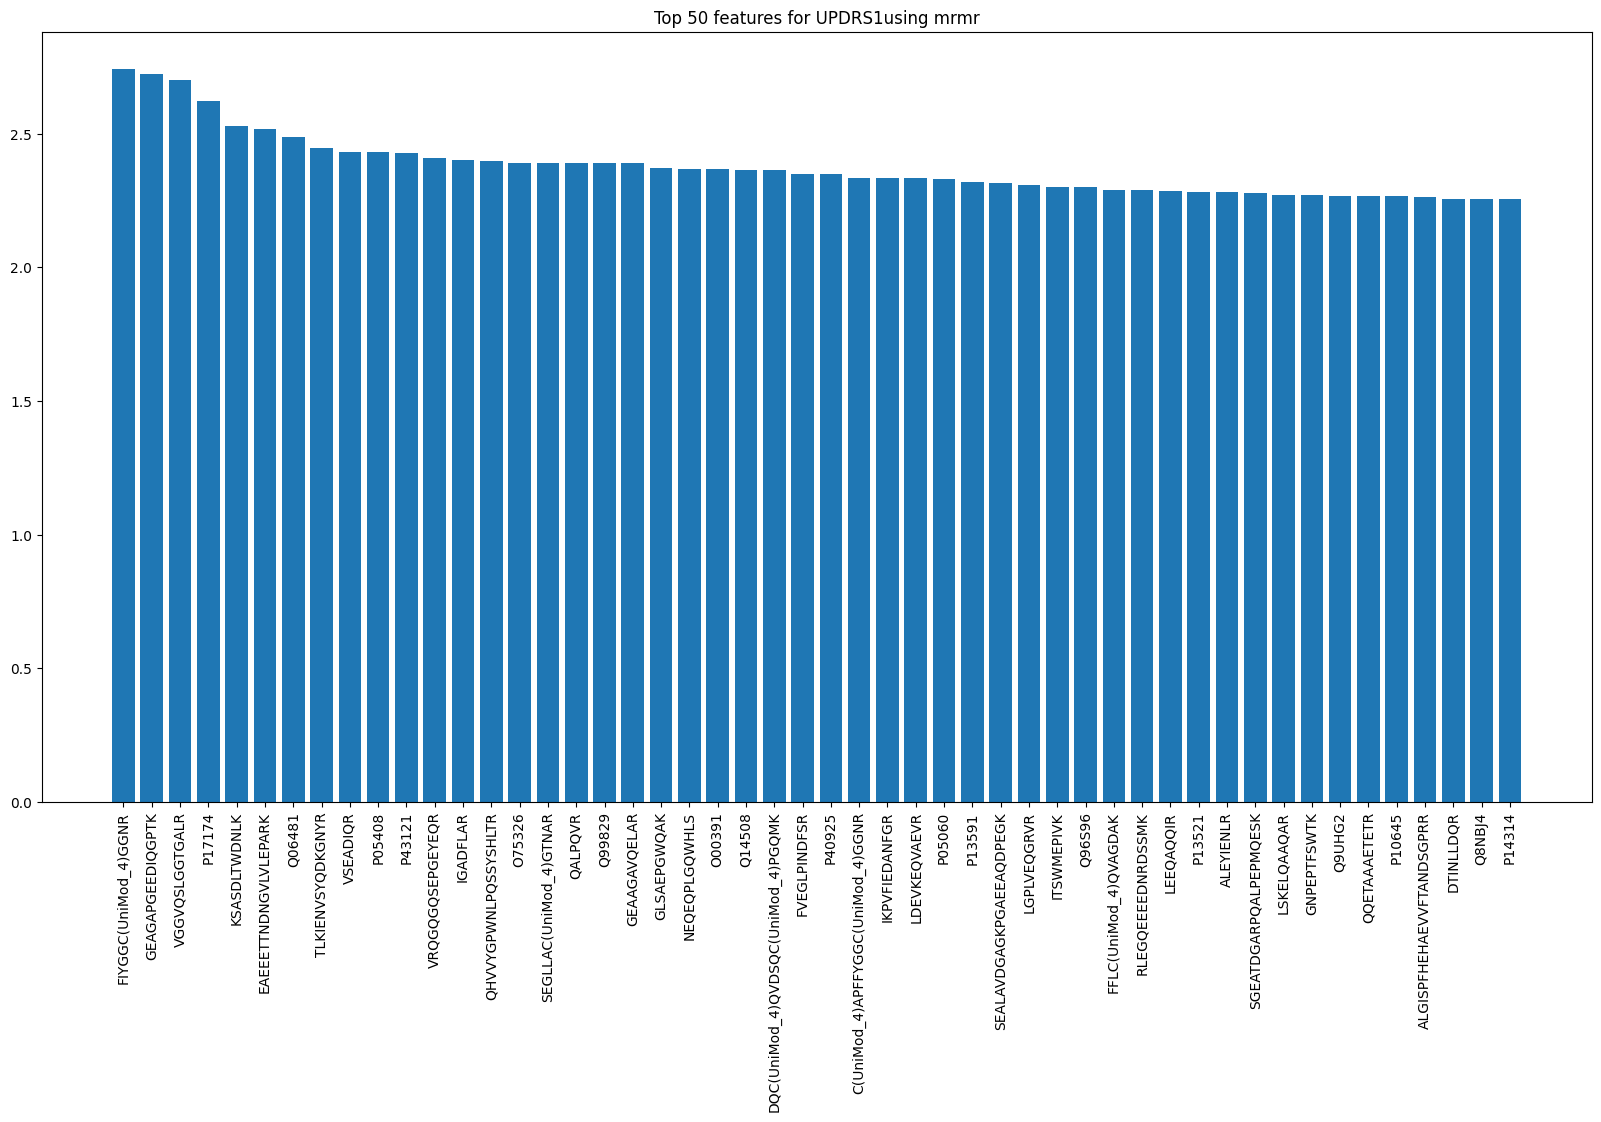

100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


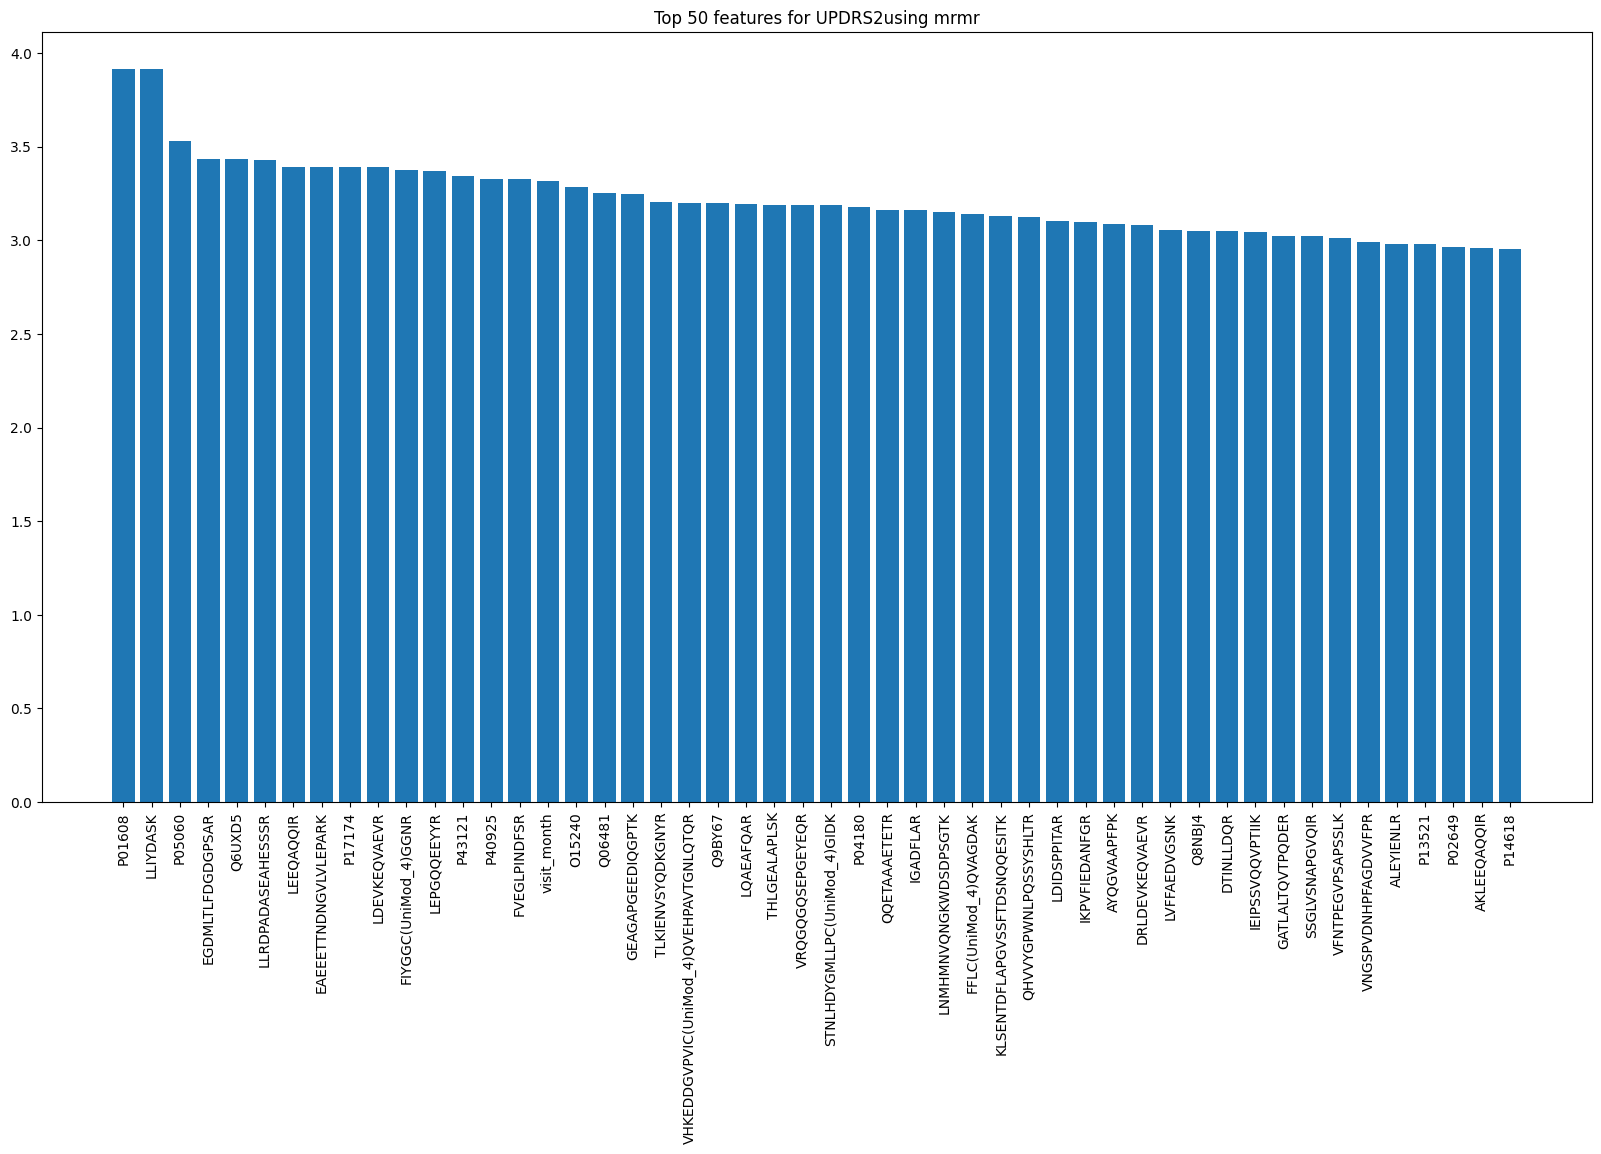

100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


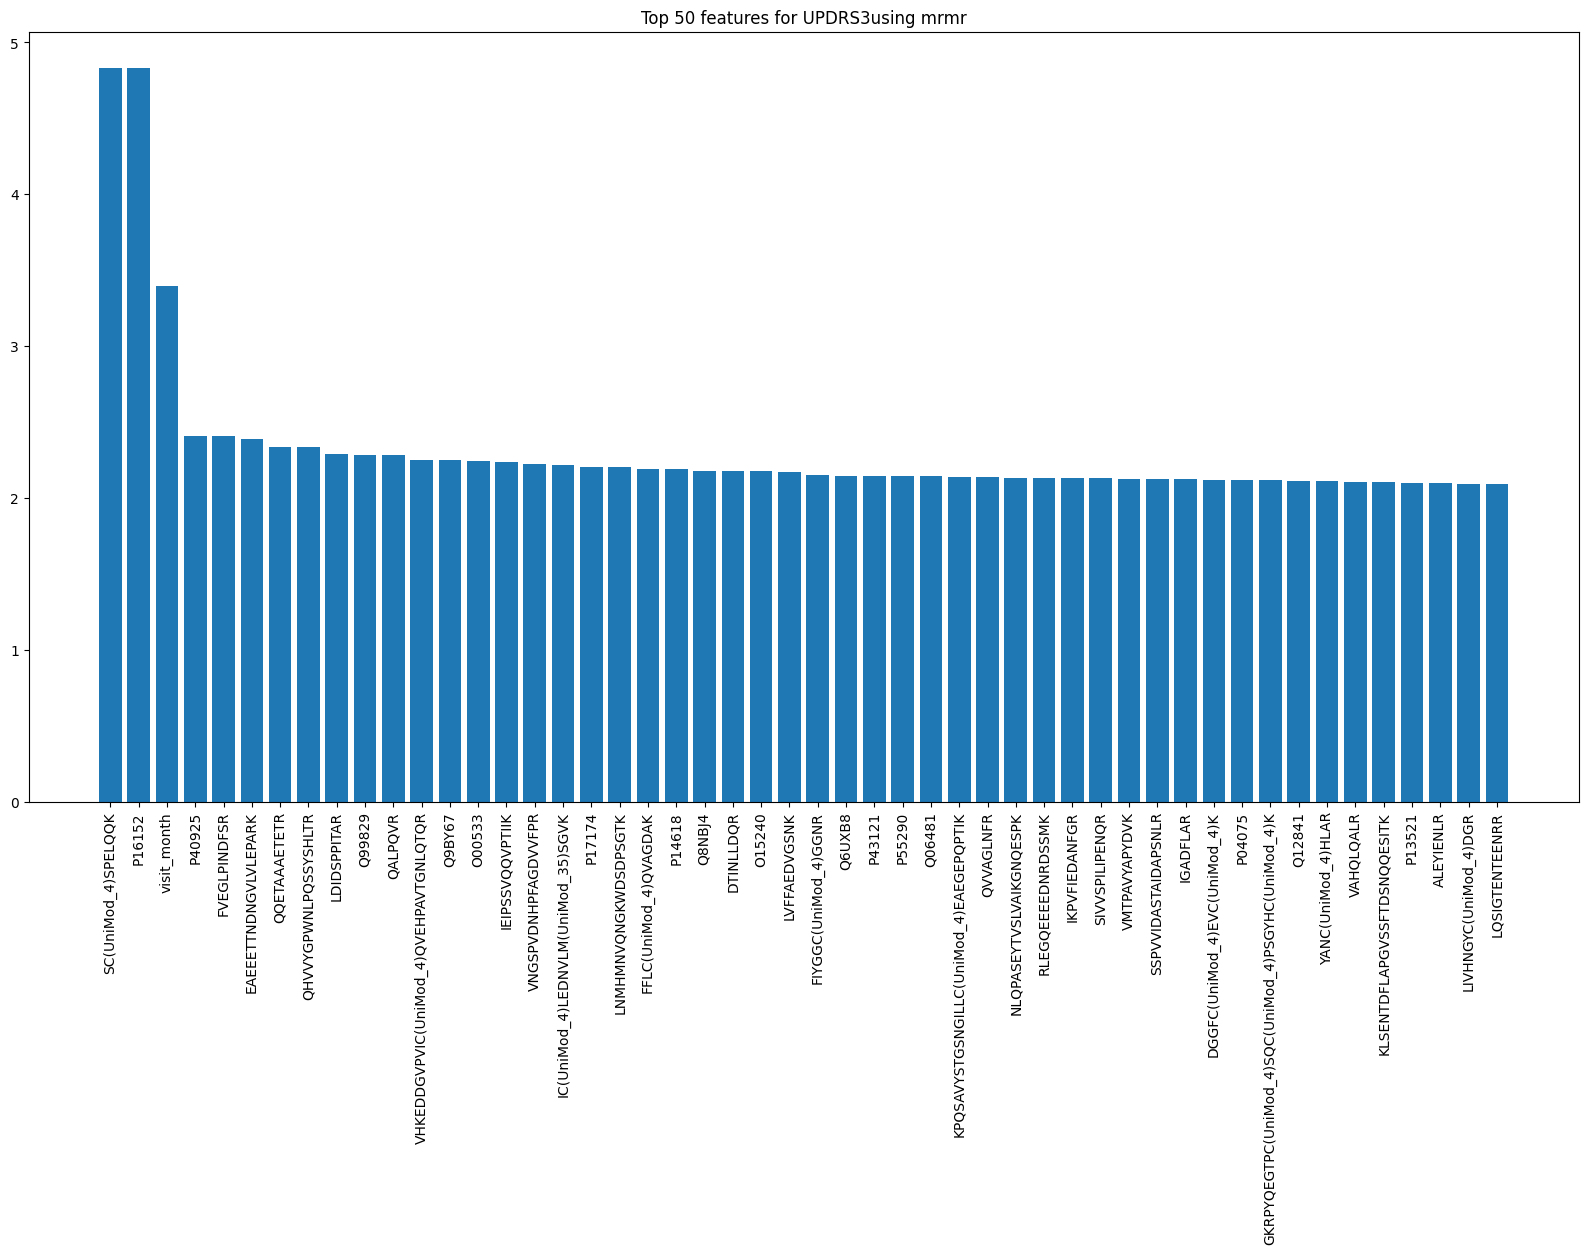

100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


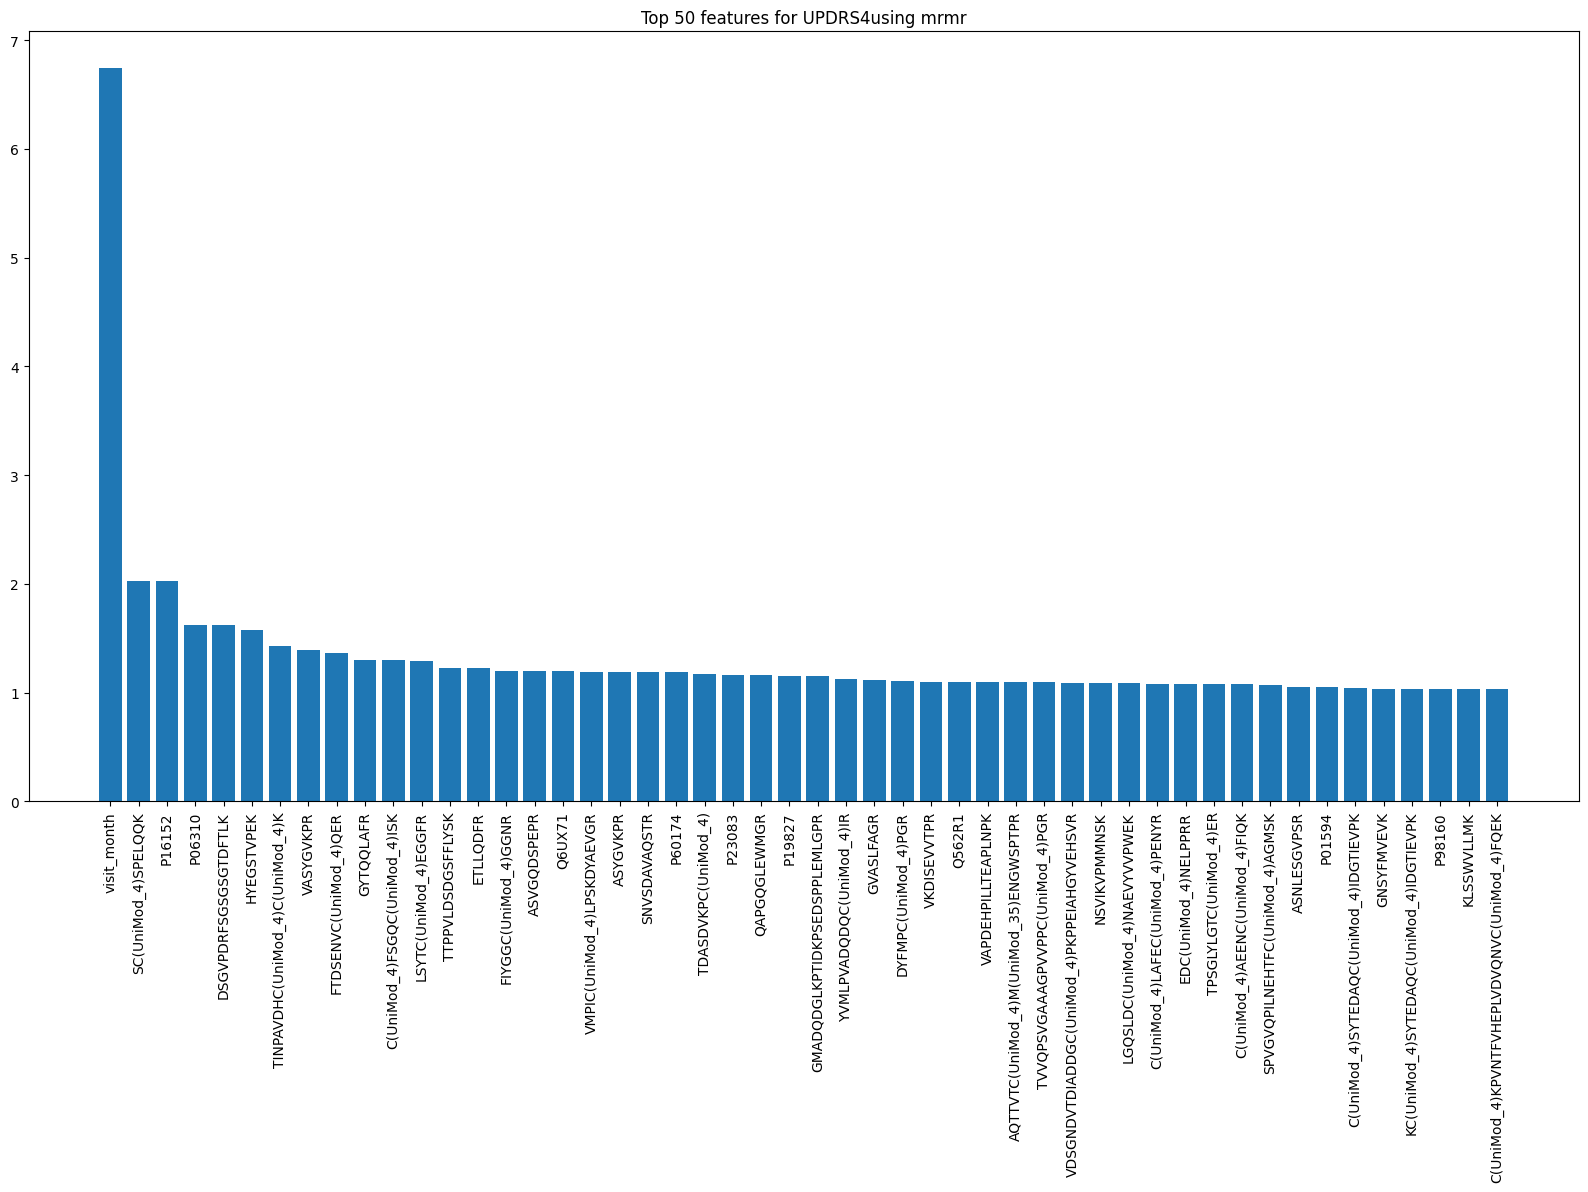

In [27]:
list_of_dataframes,list_of_list_of_features = feature_selection(list_of_dataframes)


In [28]:

scalers=[None,None,None,None]

list_of_dataframes,scalers =  scale_fit_transform_NeuralNetwork(list_of_dataframes, True,scalers,list_of_list_of_features)

0
1
2
3


<a id="8.2"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    8.2 Training </span>
    
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

In [29]:
#SIMPLE ESTIMATION LOOP:

estimates = optimize(df_clinical_EDA)

estimates

{(0, 'updrs_1'): 5.0,
 (0, 'updrs_2'): 3.0,
 (0, 'updrs_3'): 17.0,
 (3, 'updrs_1'): 4.0,
 (3, 'updrs_2'): 5.0,
 (3, 'updrs_3'): 19.0,
 (6, 'updrs_1'): 6.0,
 (6, 'updrs_2'): 6.0,
 (6, 'updrs_3'): 20.0,
 (9, 'updrs_1'): 5.0,
 (9, 'updrs_2'): 6.0,
 (9, 'updrs_3'): 19.0,
 (12, 'updrs_1'): 5.0,
 (12, 'updrs_2'): 5.0,
 (12, 'updrs_3'): 19.0,
 (18, 'updrs_1'): 6.0,
 (18, 'updrs_2'): 6.0,
 (18, 'updrs_3'): 19.0,
 (24, 'updrs_1'): 6.0,
 (24, 'updrs_2'): 5.0,
 (24, 'updrs_3'): 21.0,
 (30, 'updrs_1'): 7.0,
 (30, 'updrs_2'): 6.0,
 (30, 'updrs_3'): 21.0,
 (36, 'updrs_1'): 7.0,
 (36, 'updrs_2'): 5.0,
 (36, 'updrs_3'): 23.0,
 (42, 'updrs_1'): 7.0,
 (42, 'updrs_2'): 7.0,
 (42, 'updrs_3'): 23.0,
 (48, 'updrs_1'): 6.0,
 (48, 'updrs_2'): 5.0,
 (48, 'updrs_3'): 19.0,
 (54, 'updrs_1'): 7.0,
 (54, 'updrs_2'): 9.0,
 (54, 'updrs_3'): 26.0,
 (60, 'updrs_1'): 5.0,
 (60, 'updrs_2'): 5.0,
 (60, 'updrs_3'): 17.0,
 (72, 'updrs_1'): 7.0,
 (72, 'updrs_2'): 8.0,
 (72, 'updrs_3'): 29.0,
 (84, 'updrs_1'): 6.5,
 (84, 'up

#### 4 SIMPLE MODELS FOR 1 MONTH CLASSIFICATION:

In [30]:
"""
models = {}
MONTHS = [0,6,12,18,24,30,36,42,48,54,60,72,84,96]

df_copy = df.copy()
y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
X_cols = [col for col in df_copy.columns if col not in y_cols]

for month in MONTHS:
    
   
    # Define X and y:
    X = df_copy[X_cols]
    y = df_copy[y_cols]
        # train only on the data where visit_month = months:
    X = X[X['visit_month'] == month]


    print("The model with month:",month,"has : ",X.shape[0],"samples")
    # make the y_train dataframe be made from the index of the X_train dataframe:
    y = y.loc[X.index]

    # do a train test split on the train data:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     #fill missing values with 0:
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    #fill missing values with 0:
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    for y_col in y_cols:
        
        print("Training model for y_col: {}".format(y_col))
        y_train_new = y_train[y_col]
        y_test_new = y_test[y_col]

        dtrain = xgb.DMatrix(X_train, label=y_train_new)
        dtest = xgb.DMatrix(X_test, label=y_test_new)
        evallist = [(dtest, "eval"), (dtrain, "train")]

        params = {
            "eval_metric": "rmse",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "seed": 42
        }
        num_round = 1000
        evals_result = {}
        #turn on logging every 50 iterations:
        verbose_eval = 0
        model = xgb.train(
            params,
            dtrain,
            num_round,
            evallist,
            evals_result=evals_result,
            early_stopping_rounds=10,
            verbose_eval=verbose_eval,
            custom_metric=smape
        )
        models[y_col+"_"+str(month)] = model
        #calculate r2 score for each model:
        y_pred = model.predict(dtest)
        r2 = r2_score(y_test_new, y_pred)
        print("R2 score for model: {}".format(r2))

"""

'\nmodels = {}\nMONTHS = [0,6,12,18,24,30,36,42,48,54,60,72,84,96]\n\ndf_copy = df.copy()\ny_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]\nX_cols = [col for col in df_copy.columns if col not in y_cols]\n\nfor month in MONTHS:\n    \n   \n    # Define X and y:\n    X = df_copy[X_cols]\n    y = df_copy[y_cols]\n        # train only on the data where visit_month = months:\n    X = X[X[\'visit_month\'] == month]\n\n\n    print("The model with month:",month,"has : ",X.shape[0],"samples")\n    # make the y_train dataframe be made from the index of the X_train dataframe:\n    y = y.loc[X.index]\n\n    # do a train test split on the train data:\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n     #fill missing values with 0:\n    X_train = X_train.fillna(0)\n    X_test = X_test.fillna(0)\n\n    #fill missing values with 0:\n    y_train = y_train.fillna(0)\n    y_test = y_test.fillna(0)\n\n    for y_col in y_cols:\n        \n        print("Tra

In [31]:
models = {}
df_copy = df.copy()
y_cols = ["updrs_1","updrs_2","updrs_3","updrs_4"]
X_cols = [col for col in df_copy.columns if col not in y_cols]

search_space = {
        "eval_metric": "rmse",
        "eta": hp.uniform("eta", 0.01, 0.5),
        "max_depth": hp.choice("max_depth", np.arange(1, 5, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 10),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "lambda": hp.uniform("lambda", 0, 2),
        "alpha": hp.uniform("alpha", 0, 2),
        "seed": 42
    }

name ="test"

models_dicts = train_no_mlflow(search_space, name, df_copy)


    

Dataset loaded, split into train test... ready to run hyperoptimalization!
[0]	eval-rmse:7.67289	eval-SMAPE:85.79262	train-rmse:7.68029	train-SMAPE:86.12481
[999]	eval-rmse:5.91820	eval-SMAPE:61.10160	train-rmse:4.40867	train-SMAPE:43.30640
Stopping after 1000 rounds                            
58.276922                                             
min_eval_error                                        
100000                                                
[0]	eval-rmse:7.76792	eval-SMAPE:88.10087	train-rmse:7.79361	train-SMAPE:88.94547
[999]	eval-rmse:5.81362	eval-SMAPE:60.37974	train-rmse:5.03253	train-SMAPE:51.96165
Stopping after 1000 rounds                                             
58.211845                                                              
min_eval_error                                                         
58.276922                                                              
[0]	eval-rmse:6.94940	eval-SMAPE:71.36832	train-rmse:6.92852	train-SMAPE:70.32672
[99

In [32]:
test_data_path = "../input/amp-parkinsons-disease-progression-prediction/example_test_files/"
df_peptides_test = pd.read_csv(test_data_path + "test_peptides.csv")
df_proteins_test = pd.read_csv(test_data_path + "test_proteins.csv")
df_clinical_test = pd.read_csv(test_data_path + "test.csv")
imputer_path = "../input/imputer/imputer.pkl"
df_test = run_test_pipeline(df_peptides_test,df_proteins_test,df_clinical_test,imputer_path)




Done with feature engineering...


In [33]:
df_test = df_test[[ 'visit_month',
                    'PeptideAbundanceSum',
                    'PeptideAbundanceStd',
                    'PeptideAbundanceMin',
                    'PeptideAbundanceMax',
                    'PeptideAbundanceMedian',
                    'PeptideCount',
                    'NPXSum',
                    'NPXStd',
                    'NPXMin',
                    'NPXMax',
                    'NPXMedian',
                    'ProteinCount']]

df_test = df_test.fillna(0)

#make a prediction on the first row of the test data:



#### Deep Learning

2023-03-29 13:42:53.408928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 0s 432us/step


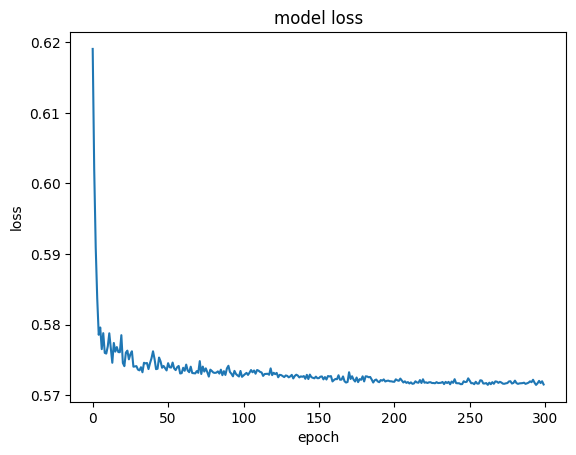

17/17 [==============================] - 0s 374us/step


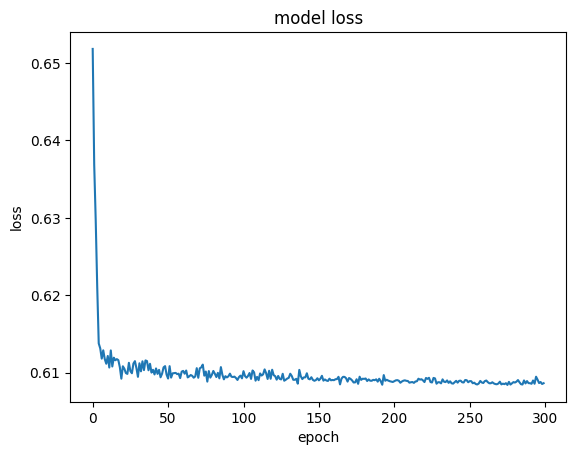

17/17 [==============================] - 0s 447us/step


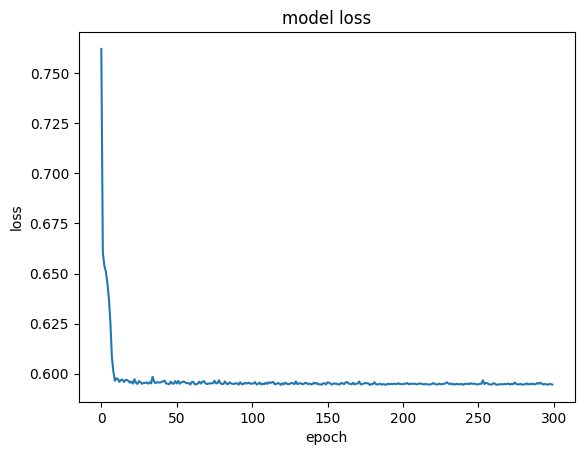

10/10 [==============================] - 0s 474us/step


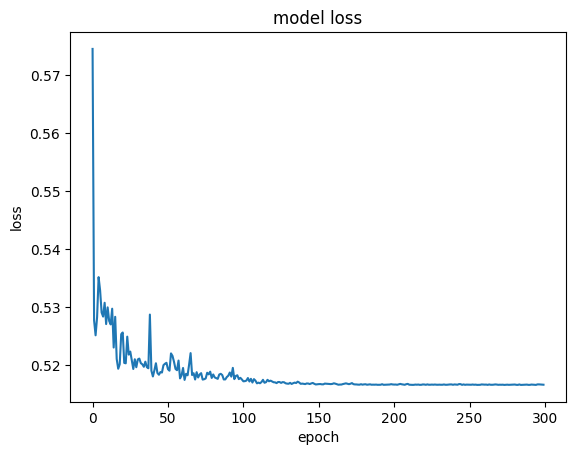

In [34]:
# train models:
models_nn = train_neural_networks(list_of_dataframes)


In [35]:
#run test data pipeline before prediction:
IS_ONLINE = False
IS_TEST = True
test_peptides = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv")
test_proteins = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv")
test = pd.read_csv("../input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv")
list_of_test_dataframes, _, _ = run_train_pipeline_deep_learning(IS_ONLINE,IS_TEST,test_peptides,test_proteins,test, list_of_old_peptides,list_of_old_proteins)

In [36]:
IS_FIT = False          
list_of_test_dataframes,scalers =  scale_fit_transform_NeuralNetwork(list_of_test_dataframes, IS_FIT,scalers, list_of_list_of_features)



In [37]:
list_of_test_dataframes

[    FIYGGC(UniMod_4)GGNR  visit_month  ALGISPFHEHAEVVFTANDSGPRR  QALPQVR  \
 0                    NaN     0.000000                       NaN      NaN   
 1                    NaN     0.000000                       NaN      NaN   
 2                    NaN     0.000000                       NaN      NaN   
 3                    NaN     0.000000                       NaN      NaN   
 4               0.324068     0.000000                  0.060173      NaN   
 5               0.324068     0.000000                  0.060173      NaN   
 6               0.324068     0.000000                  0.060173      NaN   
 7               0.324068     0.000000                  0.060173      NaN   
 8               0.356504     0.055556                  0.052383      NaN   
 9               0.356504     0.055556                  0.052383      NaN   
 10              0.356504     0.055556                  0.052383      NaN   
 11              0.356504     0.055556                  0.052383      NaN   

In [38]:
#do a prediciton:
X_pred_np = list_of_test_dataframes[0]

new_df = X_pred_np
# choose first row and make it a dataframe:

new_df= new_df.fillna(0)

#make a prediction on the first row of the test data:
y_pred = models_nn["updrs_1"].predict(new_df)

1/1 [==============================] - 0s 9ms/step


In [39]:
y_pred

array([[5.784537 ],
       [5.784537 ],
       [5.784537 ],
       [5.784537 ],
       [4.6044683],
       [4.6044683],
       [4.6044683],
       [4.6044683],
       [4.954777 ],
       [4.954777 ],
       [4.954777 ],
       [4.954777 ],
       [5.749144 ],
       [5.749144 ],
       [5.749144 ],
       [5.749144 ]], dtype=float32)

<a id="9"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>9. Explainability</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

<a id="9.1"></a>
<left> <span style="font-family:Verdana"> <span style="padding:5px; display:fill; background-color:#686963;font-size:150%; font-weight:500; color:white;overflow:hidden;"> 
    9.1 SHAP </span>

In [40]:
#load JS visualization code to notebook
if ~IS_ONLINE:
    shap.initjs()






[0.5]


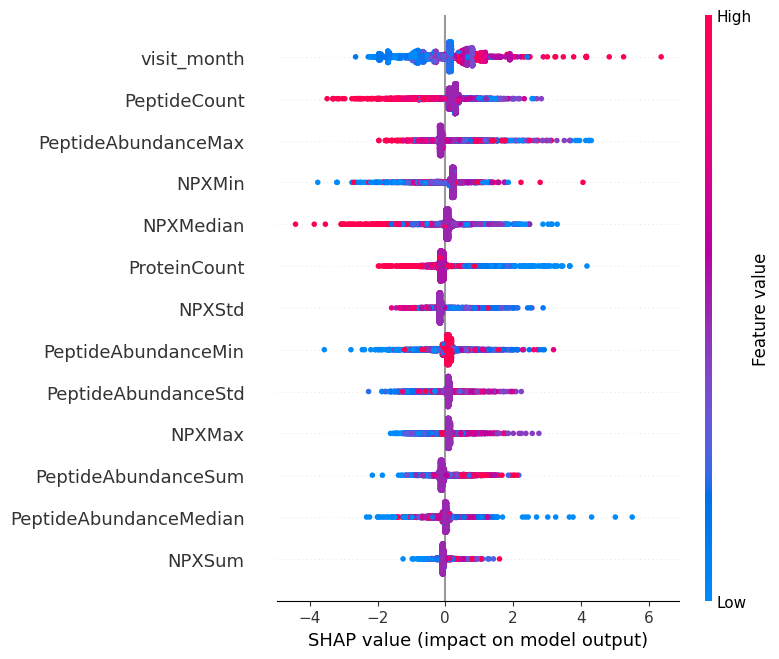

In [41]:
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
if ~IS_ONLINE:
    explainer = shap.TreeExplainer(models_dicts["updrs_1"])
    #print
    print(explainer.expected_value)
    # calculate shap values. This is what we will plot.

    shap_values = explainer.shap_values(df_copy[X_cols])

    # plot the feature attributions
    shap.summary_plot(shap_values, df_copy[X_cols])

<a id="10"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>10. Conclusion</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>
    

<a id="11"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>11. Inferrence</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

In [55]:
def get_predictions_deep_learning(IS_ONLINE,IS_TEST,models,peptides,proteins,test, list_of_old_peptides,list_of_old_proteins,list_of_list_of_features,scalers):
    """
    Predictorfunction for deep learning models
    
    Input: dfs_cleaned: list of dfs with targets:

    Output: df with predictions
    """
    # do the wrangling, such that df matches the training df:
    
    list_of_output_dataframes, _, _ = run_train_pipeline_deep_learning(IS_ONLINE,IS_TEST,peptides,proteins,test, list_of_old_peptides,list_of_old_proteins)
    #copy the frames to add back the visit_id column:
    copy_frames = list_of_output_dataframes.copy()

    # save the unique visit_ids:
    unique_visit_ids = copy_frames[1]["visit_id"].unique()

    # scale the dataframes:
    IS_FIT = False   
    list_of_output_dataframes,scalers =  scale_fit_transform_NeuralNetwork(list_of_output_dataframes, IS_FIT,scalers, list_of_list_of_features)
    # add back the visit_id column:
    for i in range(len(list_of_output_dataframes)):
        list_of_output_dataframes[i]["visit_id"] = copy_frames[i]["visit_id"]
    
    # make a dataframe to store the predictions:
    results = pd.DataFrame()
    MONTHS = [0,6,12,24]
    TARGETS = ["updrs_1","updrs_2","updrs_3","updrs_4"]
    for visit_id in unique_visit_ids:
        for month in MONTHS:
            COUNTER=0
            for target in TARGETS:
                prediction_id = str(visit_id) + "_" + target + "_" + "plus_" + str(month) + "_months"
                
                
                # choose the correct dataframe from the 3 models
                df_test = list_of_output_dataframes[COUNTER]
                

                #choose the correct rows from the current visit_id:
                df_test_rows = df_test[df_test["visit_id"] == visit_id]
                
                #drop the visit_id column for the prediction:
                X_pred = df_test_rows.drop(columns=["visit_id"])
                
                
                # change the month variable based on the future
                X_pred['visit_month'] = X_pred['visit_month'] + month
                
                #choose the correct features for the model:
                list_of_correct_features = list_of_list_of_features[COUNTER]
                X_pred_cleaned = X_pred[list_of_correct_features]
                # fill NaNs with 0:
                X_pred_cleaned = X_pred_cleaned.fillna(0)
                # use the correct model to predict:
                model = models[target]
                X_pred_np = X_pred_cleaned.to_numpy().astype(np.float32)
                
                #round the prediction to the nearest integer:
            
                

                prediction = model.predict(X_pred_np)

                # make sure the predictions which are negative are set to 0:
                for i in range(len(prediction)):
                    if prediction[i] < 0:
                        prediction[i] = 0

                
                # round the prediction to the nearest integer:
                prediction = np.round(prediction)
                print("prediction: ", prediction)
                print("_________________________")
                
                #use concat instead of append, and dont pass group_key:
                results = pd.concat([results,pd.DataFrame({"prediction_id":prediction_id,"rating":prediction[0]},index=[0])],ignore_index=True)
                COUNTER+=1

    return results

In [57]:
if IS_ONLINE:
    env = amp_pd_peptide.make_env()   # initialize the environment
else:
    env = mock_api.make_env()   # initialize the environment
iter_test = env.iter_test()  

for (test,test_peptides,test_proteins,sample_submission) in iter_test:
    #different predictions for different models:
    preds_optimization = sample_submission.prediction_id.str.split('_').apply(lambda x: (int(x[1]) + int(x[5]), '_'.join(x[2:4])))
    preds_xgboost = get_predictions_single_month_simple_imputer(models_dicts,test_peptides,test_proteins,test)
    IS_TEST = True
    preds_nerual_networks = get_predictions_deep_learning(IS_ONLINE,IS_TEST,models_nn,test_peptides,test_proteins,test,list_of_old_peptides,list_of_old_proteins,list_of_list_of_features,scalers)
    
    #map predictions for the optimization model:
    pred_opt_mapped = preds_optimization.map(estimates)

    # remove NaN values:
    pred_opt_mapped = pred_opt_mapped.fillna(0)
    
    #take the average of the two predictions:
    preds_xgboost["rating"] = (preds_xgboost['rating'] + pred_opt_mapped)/2

    # remove NaN values:
    preds_xgboost["rating"] = preds_xgboost["rating"].fillna(0)

    # round the values:
    preds_xgboost["rating"] = preds_xgboost["rating"].round()


    print(preds_nerual_networks)

    env.predict(preds_nerual_networks)

Done with feature engineering...
1/1 [==============================] - 0s 10ms/step
prediction:  [[6.]
 [6.]
 [6.]
 [6.]]
_________________________
1/1 [==============================] - 0s 10ms/step
prediction:  [[4.]
 [4.]
 [4.]
 [4.]]
_________________________
1/1 [==============================] - 0s 10ms/step
prediction:  [[19.]
 [19.]
 [19.]
 [19.]]
_________________________
1/1 [==============================] - 0s 10ms/step
prediction:  [[0.]
 [0.]
 [0.]
 [0.]]
_________________________
1/1 [==============================] - 0s 10ms/step
prediction:  [[6.]
 [6.]
 [6.]
 [6.]]
_________________________
1/1 [==============================] - 0s 10ms/step
prediction:  [[6.]
 [6.]
 [6.]
 [6.]]
_________________________
1/1 [==============================] - 0s 9ms/step
prediction:  [[20.]
 [20.]
 [20.]
 [20.]]
_________________________
1/1 [==============================] - 0s 10ms/step
prediction:  [[0.]
 [0.]
 [0.]
 [0.]]
_________________________
1/1 [===========================

<a id="12"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Meirio;text-align:left;display:fill;border-radius:5px;background-color:#8AA29E;overflow:hidden"><b>12. Sources</b></div>
<left> <a href="#top" role="button" aria-pressed="true">Back to ToC</a>

1. Colours and colour - palette from: https://coolors.co/db5461-686963-8aa29e-3d5467-f1edee
2. mRmR - feature selection algorithm: https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b
3. Feature Selection paper from Westad: https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/3042897 